In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("../")

## Example 2: Multi-timepoint modeling

In [4]:
import echidna as ec
ec.pl.activate_plot_settings()

%load_ext autoreload
%autoreload 2

As in the first example, read in your single-cell and copy number data. This time, our AnnData contains cells across multiple timepoints of treatment, "pre" and "on".

In [5]:
adata = sc.read_h5ad("data/F01_combined.h5")
wdf = pd.read_csv("data/wgs_F01_cellranger.csv", index_col="gene")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'data/F01_combined.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [4]:
# W has two out of order timepoints.
# We will define a setting to handle this behavior explicitly and uniformly.
wdf.describe()

,on_count,pre_count
count,34167.000000,34199.000000
mean,1.976021,1.973945
std,0.654976,0.671253
min,0.052669,0.052669
25%,2.000000,2.000000
50%,2.000000,2.000000
75%,2.000000,2.000000
max,4.000000,4.000000


Pre-process your data if necessary. I've already run this step and saved the processed AnnData. As before, your pre-processing should filter out low variance genes, save the raw single-cell counts in a layer, and have cluster labels for Echidna to leverage. Your timepoint label in `.obs` should label cells with the timepoint from which they stem.

In [5]:
# ec.tl.pre_process(adata, filepath="data/F01_combined.h5")

For multi-timepoint, we need to be careful about the ordering of our data. Below, specify the sequential order of the timepoint labels. These should be present in your `.obs[timepoint_label]` (specified in config) as well as in the columns of `wdf`, your CN counts. For example, our data is ordered "pre" (before treatment), then "on" (during treatment), then "post" (after treatment), and so on. Echidna will use this ordering whenever it needs to construct your data tensors using the original data you pass.

In [6]:
ec.tl.set_sort_order(
    adata,
    ["pre", "on", "on1", "on2", "post", "post1", "post1_pre2", "post1_on2", "post2"]
)

2024-07-07 03:41:56,772 | INFO : Added `.obs['echidna_split']`: the Echidna train/validation split.
 704 cells in validation set.
2024-07-07 03:41:56,784 | INFO : Added `.var[echidna_matched_genes]` : Labled True for genes contained in W.
2024-07-07 03:41:56,791 | INFO : Added `.var[echidna_W_on_count]` : CN entries for genes contained in W.
2024-07-07 03:41:56,791 | INFO : Added `.var[echidna_W_pre_count]` : CN entries for genes contained in W.
training loss: 0.6597 | validation loss: 0.0910:   2%| | 167/10000 [00:44<44:01,
2024-07-07 03:42:53,745 | INFO : Early stopping has been triggered.


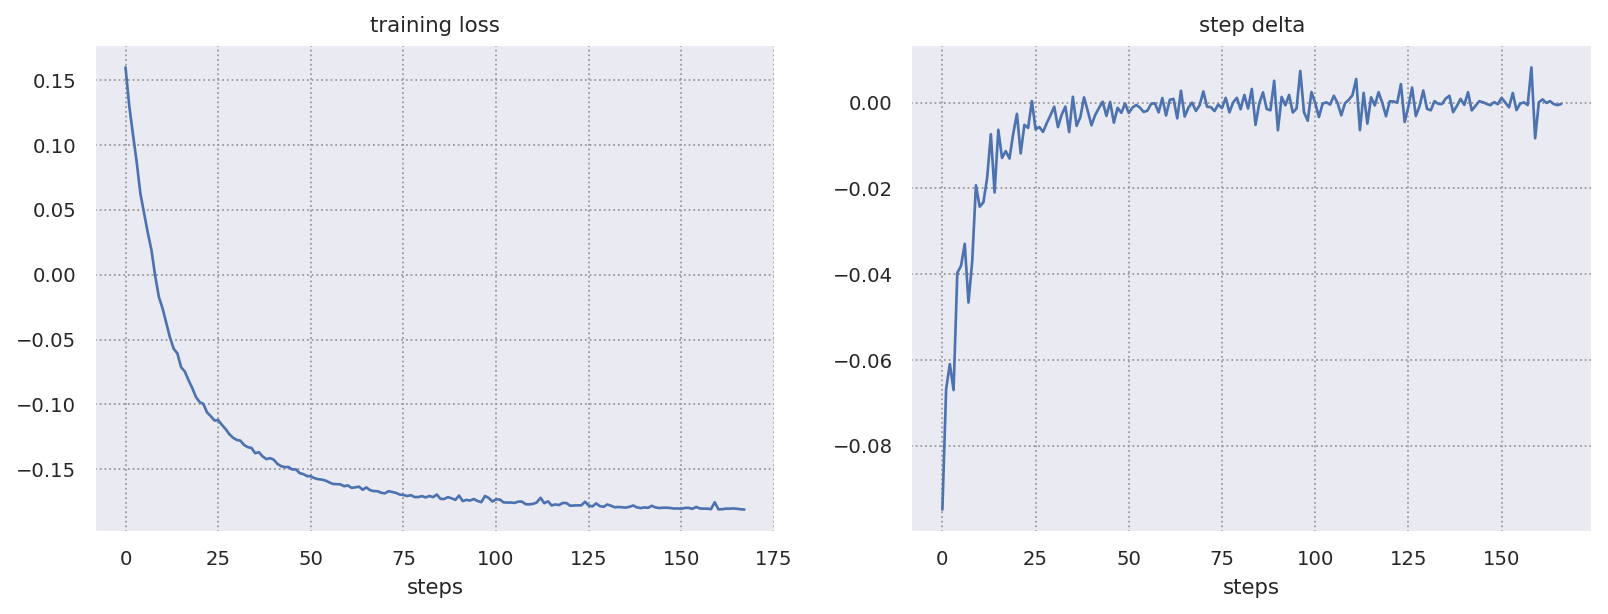

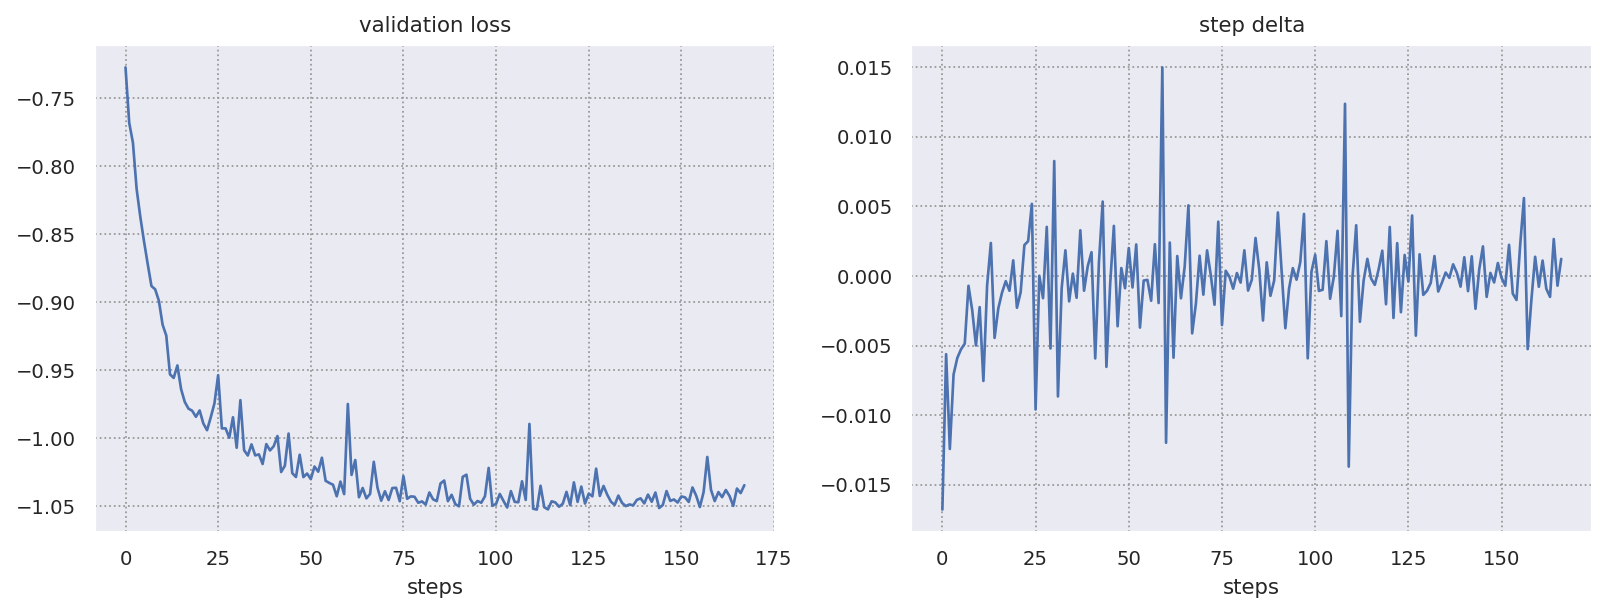

2024-07-07 03:43:22,601 | INFO : Saving echidna model with run_id 20240707-034322.


In [7]:
config = ec.tl.EchidnaConfig(
    timepoint_label = "timepoint", # `assert 'timepoint' in adata.obs.columns`
    counts_layer = "counts", # `assert 'counts' in list(adata.layers.keys())`
    clusters = "pheno_louvain", # `assert 'pheno_leiden' in adata.obs.columns`
    inverse_gamma = False, # Inverse Gamma False when we have more data
    eta_mean_init = 2., # Our genes average approximately two copies
    patience = 50, # Increase/decrease to affect early stopping
)
ec.tl.echidna_train(
     adata # Single-cell AnnData
    , wdf # Copy number  pd.DataFrame, indexed with genes
    , config # Config settings
)

Again use `ec.pl.plate_model` to visualize the plate model. We can see how our hierarchy changes with more than one timepoint.

In [1]:
ec.pl.plate_model(adata)

NameError: name 'ec' is not defined

For the sake of the example, we show how to calculate hierarchical clustering with cophenetic distances on the covariance of clusters. Select settings according to the specificities of your data.

In [2]:
ec.tl.echidna_clones(adata, method="cophenetic", cov=True)

NameError: name 'ec' is not defined

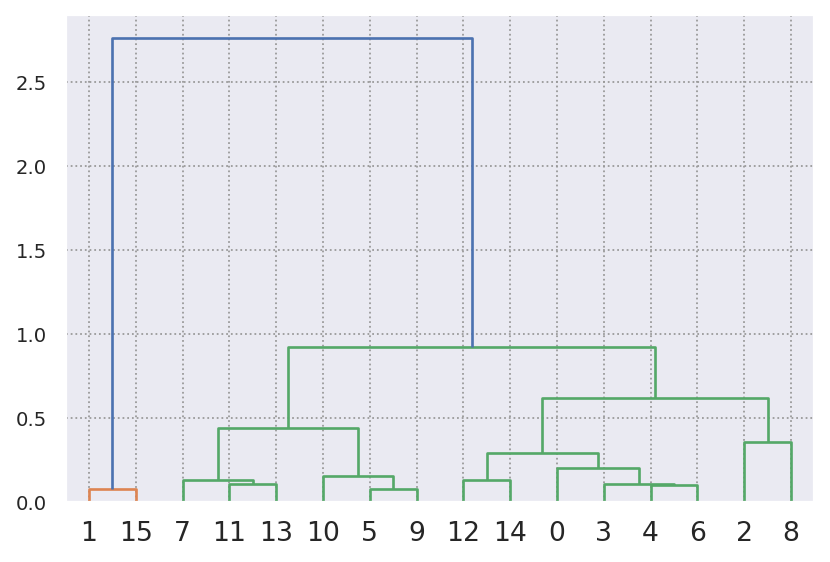

In [9]:
ec.pl.dendrogram(adata)

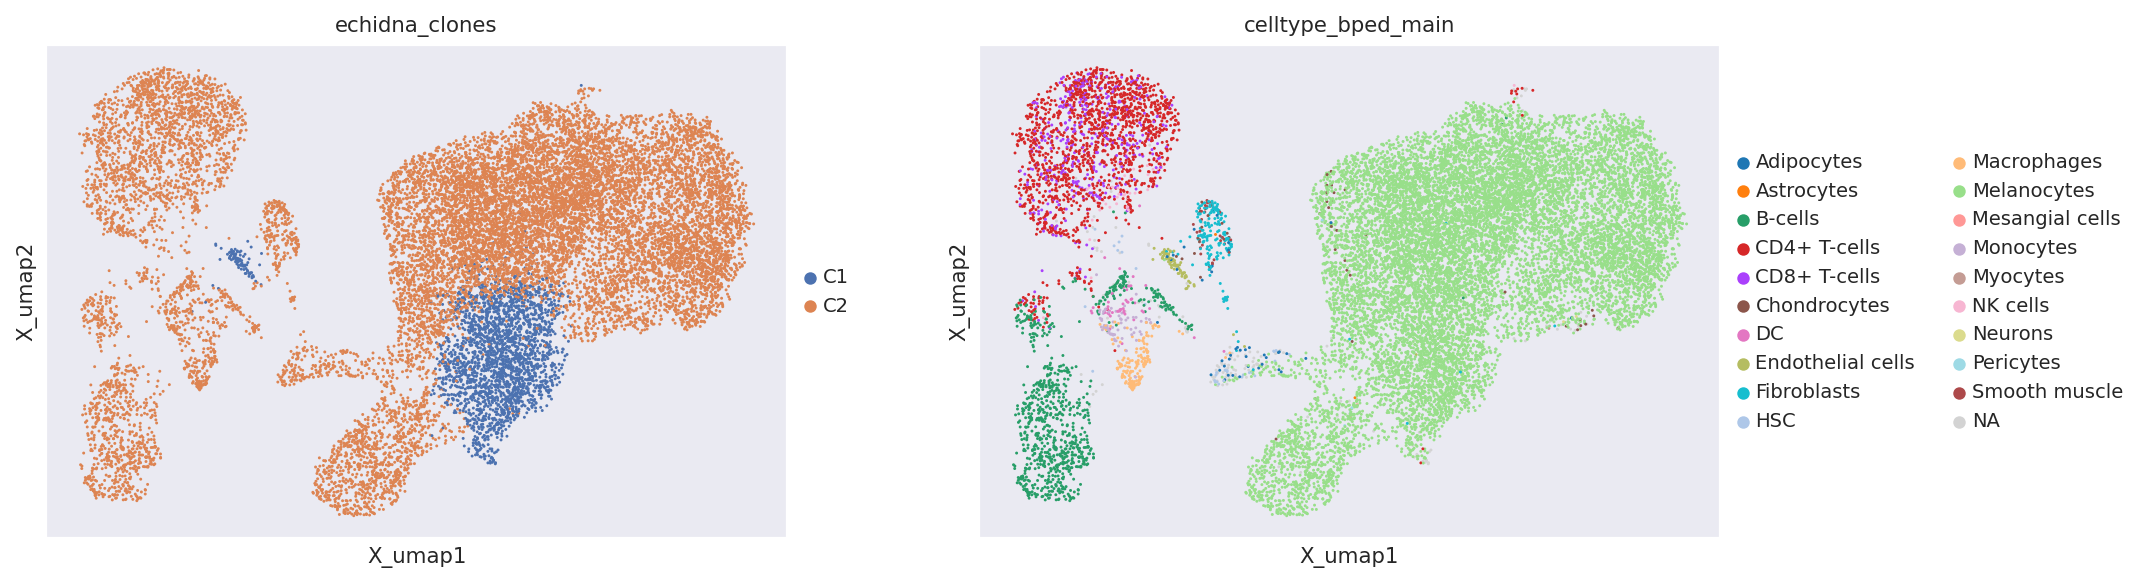

In [10]:
ec.pl.echidna(adata, ["echidna_clones", "celltype_bped_main"])

PPCs of the multi-timepoint case works the same as in the single-timepoint case. In both settings, we seek to generate data of similar distribution to our observed data.

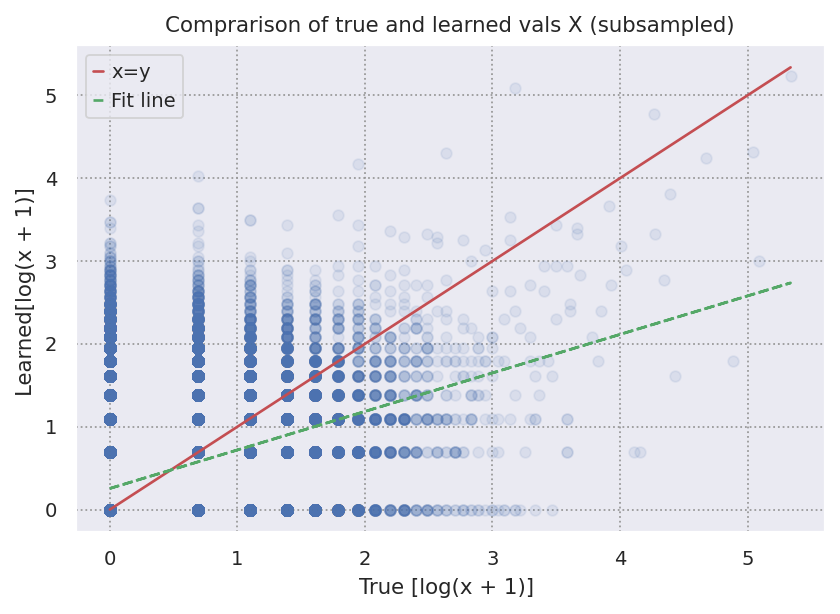

In [12]:
ec.pl.ppc(adata, "X")

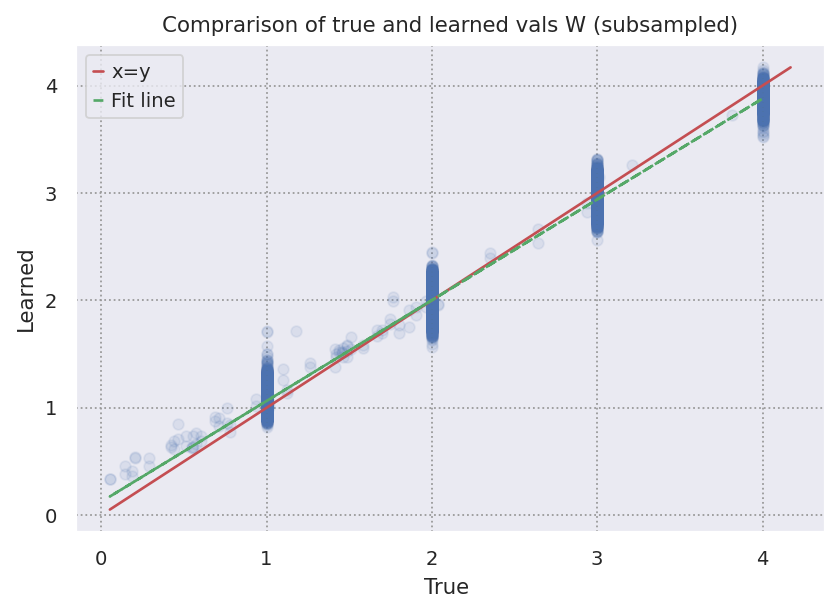

In [13]:
ec.pl.ppc(adata, "W")

training loss: 1.5610 | validation loss: 0.4186:   1%| | 68/10000 [00:16<40:36, 
2024-07-07 03:44:38,498 | INFO : Early stopping has been triggered.


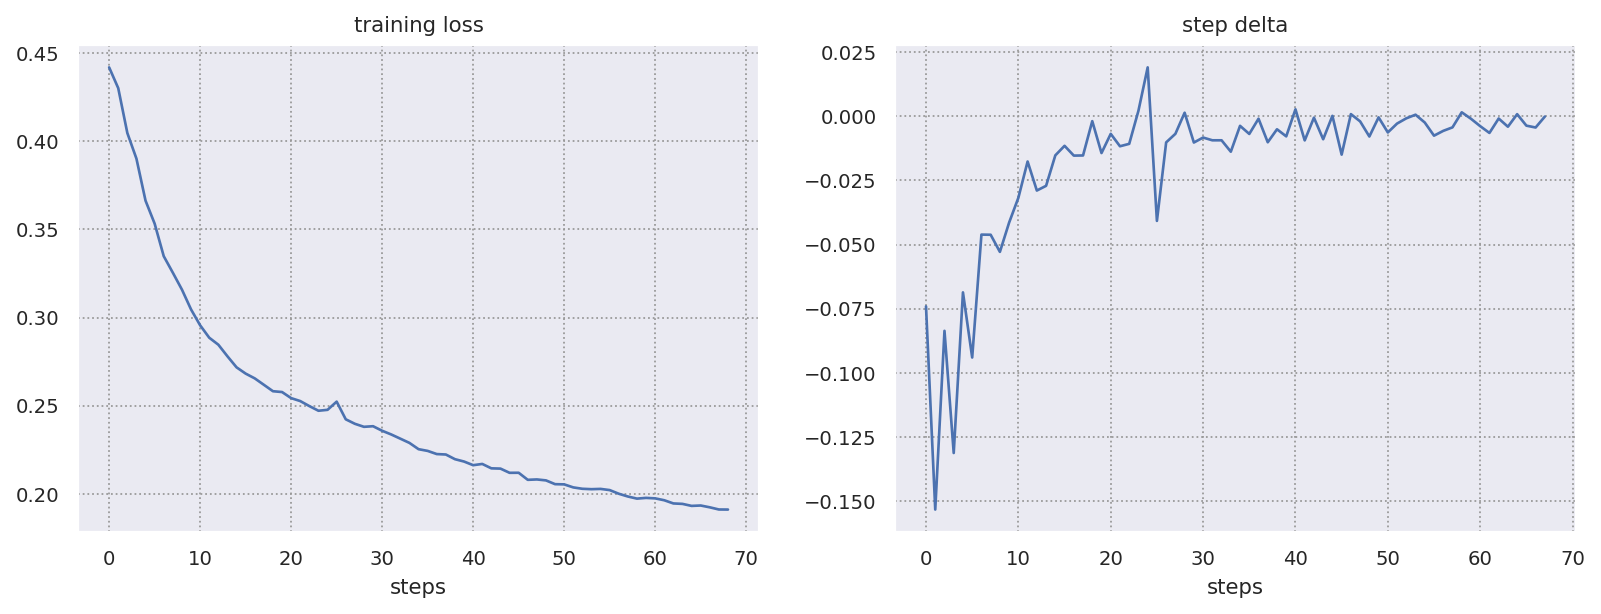

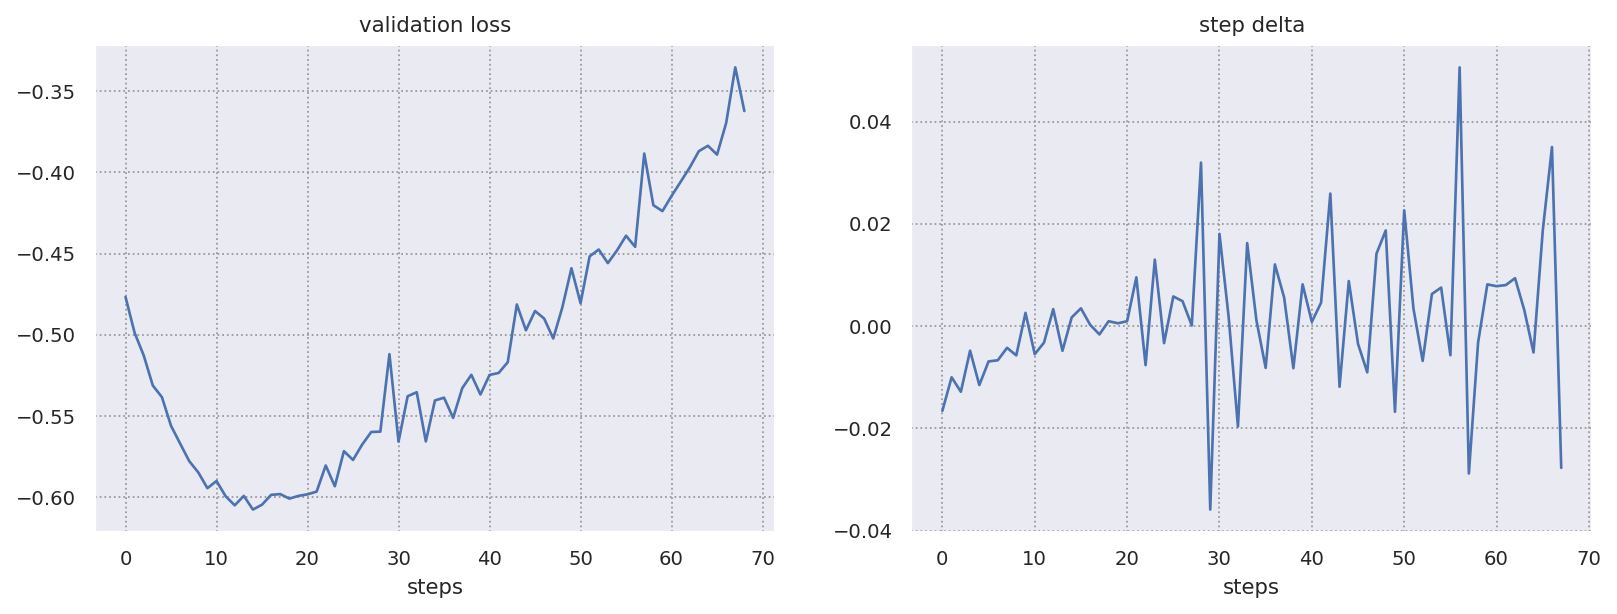

2024-07-07 03:45:05,308 | INFO : Saving echidna model with run_id 20240707-034505.


In [14]:
ec.tl.simulate(adata)

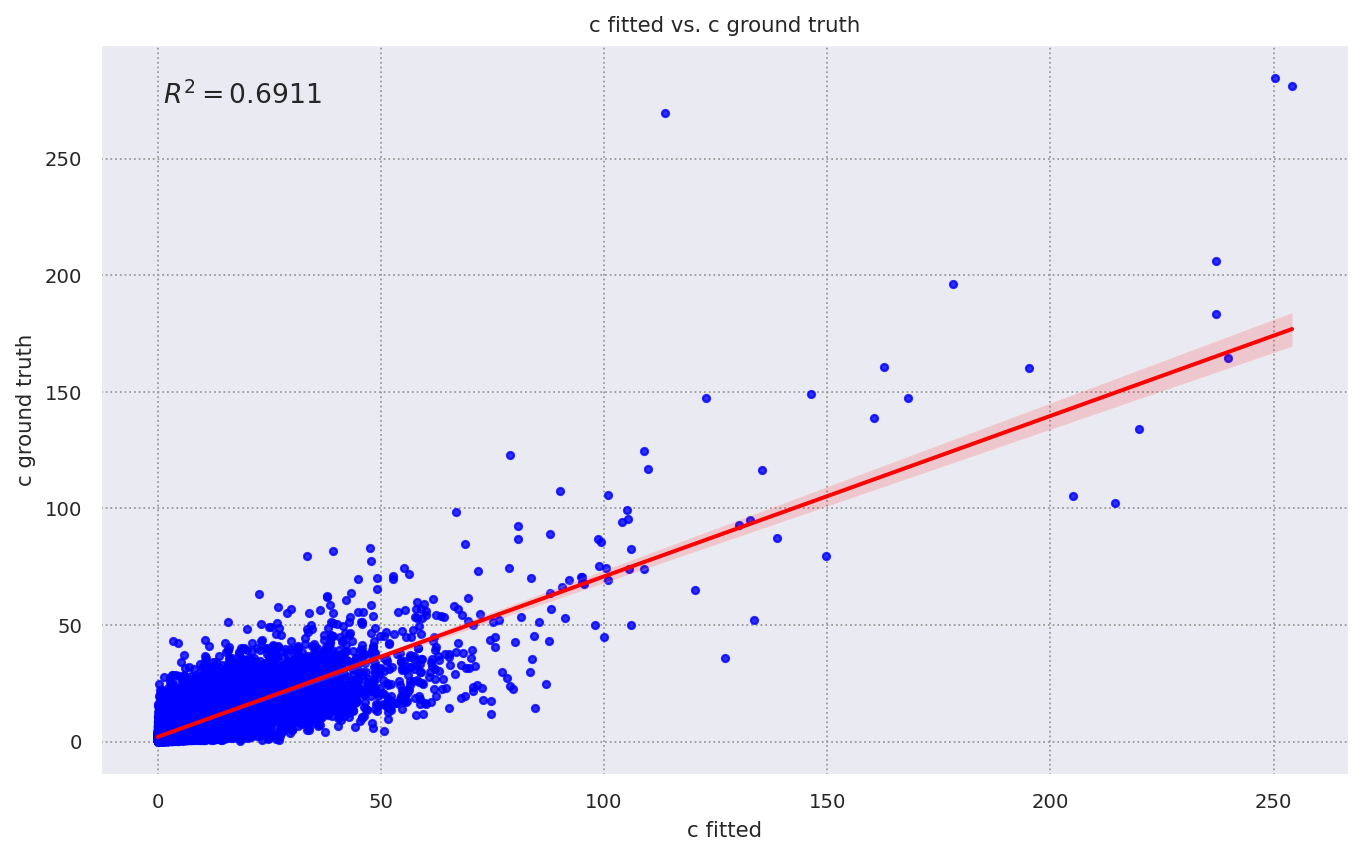

In [15]:
ec.pl.ppc(adata, "c")

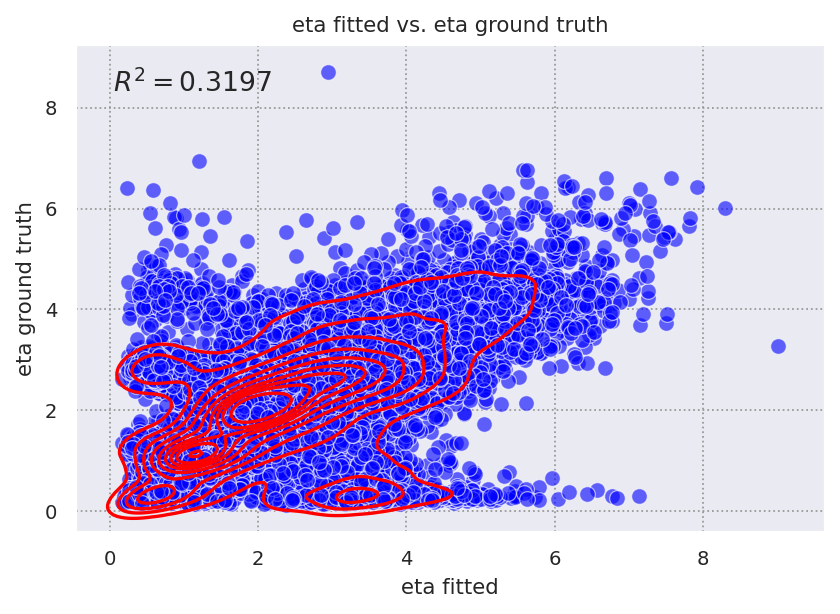

In [16]:
ec.pl.ppc(adata, "eta")

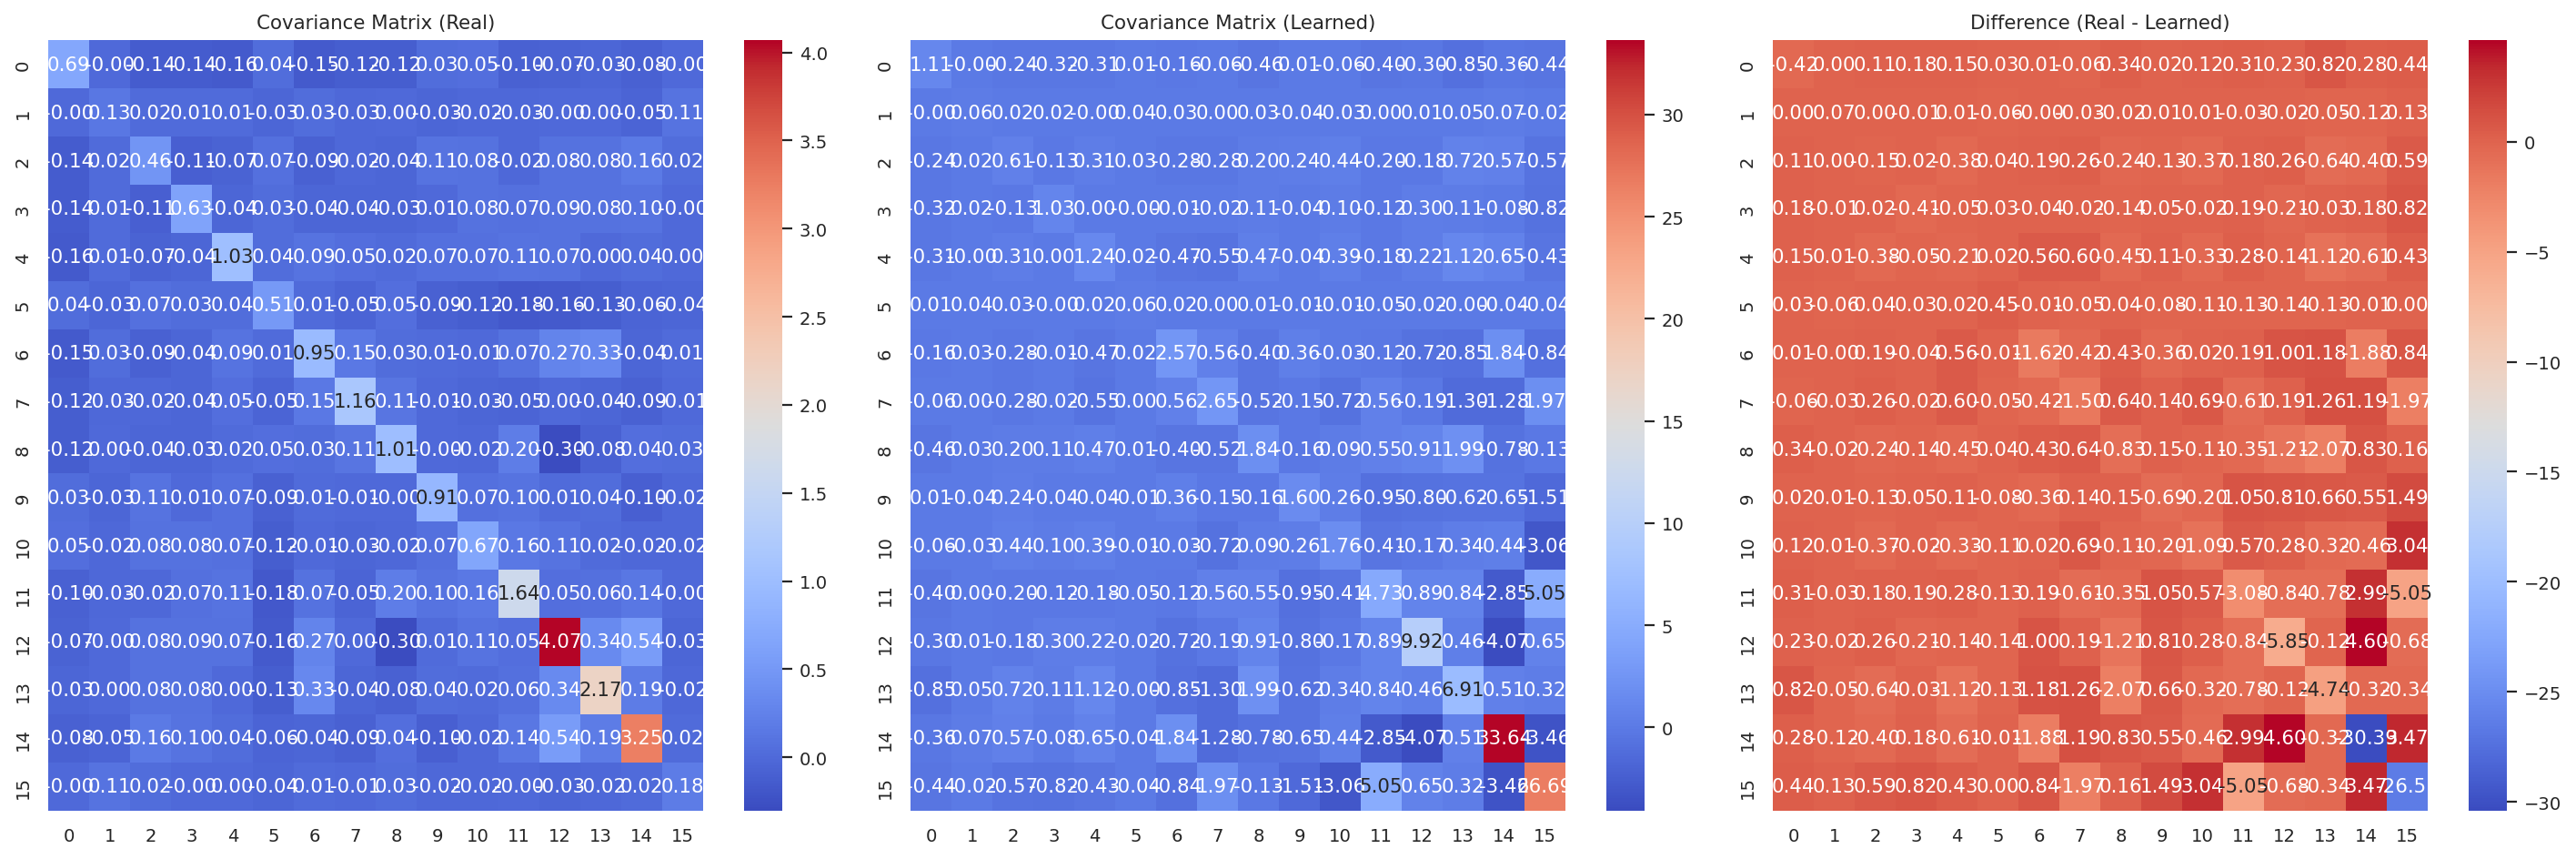

In [17]:
ec.pl.ppc(adata, "cov")

When sampling data with multi-timepoint configuration, variables with time-dimension will sample according to the timepoints in `.obs[timepoint_label]`.

In [18]:
ec.tl.sample(adata, ["X", "W"])

tensor([[ 0.0597, -0.0576,  0.5660,  ...,  0.5643,  2.9853,  0.2905],
        [ 0.8784,  0.9672,  2.3957,  ...,  0.8809, -2.3678,  0.5721],
        [ 1.6322,  0.5594,  1.5222,  ...,  1.8394, -1.4872,  0.7551],
        ...,
        [ 3.2581,  2.1126,  1.9589,  ...,  2.4557,  1.0692,  1.4696],
        [ 3.9202,  2.0453,  3.1008,  ...,  2.5790,  4.5241,  1.3951],
        [ 2.3963,  0.3384,  2.4157,  ...,  2.7722,  2.4134,  0.5698]],
       device='cuda:0')

If you ever need to clear space in your hard drive, run the following command to clear out the Echidna save data.

In [19]:
# ec.tl.reset_echinda_memory()